In [43]:
import os
import numpy as np
from tqdm import tqdm
import nibabel as nib
import raster_geometry as rg
import cv2
import matplotlib.pyplot as plt

In [30]:
mask_prob = nib.load("/workspace/FCD_mask.nii.gz").get_fdata()
mask_prob[:40, :, :] = 0
mask_prob[-40:, :, :] = 0
mask_prob[:, :40, :] = 0
mask_prob[:, -40:, :] = 0
mask_prob[:, :, :40] = 0
mask_prob[:, :, -40:] = 0

high_left_corners = []
sphere = rg.sphere(40, 8)

for i in tqdm(range(mask_prob.shape[0] - 40)):
    for j in range(mask_prob.shape[1] - 40):
        for k in range(mask_prob.shape[2] - 40):
            cube = mask_prob[i:i+40, j:j+40, k:k+40]
            if np.all(cube[sphere] == 1):
                high_left_corners.append((i, j, k))

100%|██████████| 157/157 [02:46<00:00,  1.06s/it]


In [34]:
def get_random_train_mask():
    files = os.listdir('../data/raw/patches/labels')
    patients_exclude = ['n3', 'n11', 'n13', 'G061', 'G081', 'G258', 'n23', 'n37', 'n64', 'n70']
    patients_exclude = ['sub-' + patient + '.nii.gz' for patient in patients_exclude]
    files = [file for file in files if file not in patients_exclude]

    file = np.random.choice(files)
    mask = (nib.load('../data/raw/patches/labels/' + file).get_fdata() > 0.5)

    return mask.astype(np.float64)


def generate_mask_from_train(shape):
    x, y, z = shape
    mask = np.zeros(shape)
    patch = np.zeros(shape)
    symm_patch = np.zeros(shape)
    
    idx = np.random.randint(len(high_left_corners))
    i, j, k = high_left_corners[idx]
    local_mask = get_random_train_mask()   # (40, 40, 40)
                
    if np.random.randn() > 0.5: 
        local_mask = local_mask[:, :, ::-1]

    patch[i:i+40, j:j+40, k:k+40] = 1
    symm_patch[x-i-40:x-i, j:j+40, k:k+40] = 1
    mask[patch.astype(bool)] = local_mask.flatten()

    return mask.astype(bool), patch.astype(bool), symm_patch.astype(bool)

In [50]:
np.load('../data/processed/patches_norm/val/imagenet_freeform1020_masks.npz')['mask'].shape

(960, 256, 256)

In [51]:
masks_resized = []
for i in range(960 // 40):
    mask, patch_mask, _ = generate_mask_from_train((197, 233, 189))
    mask = mask[patch_mask].reshape((40, 40, 40))
    for mask_slice_id in range(40):
        mask_slice = mask[:, :, mask_slice_id]
        masks_resized.append(cv2.resize(mask_slice.astype(np.uint8), (256, 256)) > 0.5)
masks_resized = np.stack(masks_resized)
masks_resized.shape

(960, 256, 256)

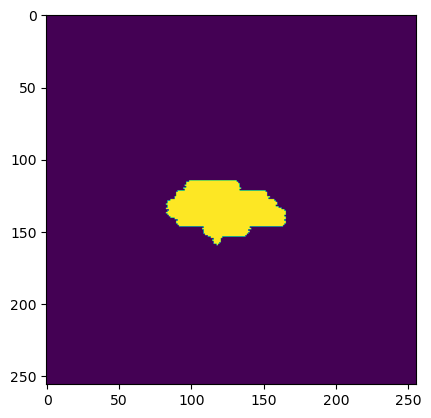

In [83]:
masks_norm = np.load('../data/processed/patches_norm/val/trainlike_masks/imagenet_freeform1020_masks.npz')['mask']
plt.imshow(masks_norm[21])

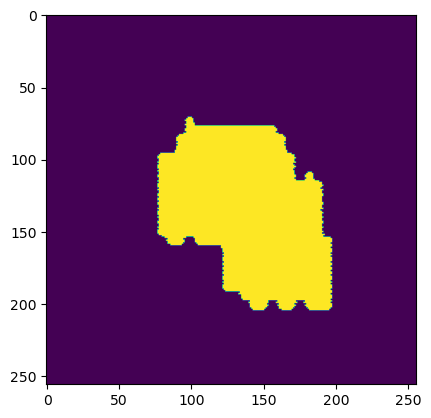

In [75]:
plt.imshow(np.load('../data/processed/patches/val/trainlike_masks/imagenet_freeform1020_masks.npz')['mask'][20])

In [52]:
np.savez('../data/processed/patches_norm/val/trainlike_masks/imagenet_freeform1020_masks.npz', mask=masks_resized.astype(np.uint8))